Imports

In [1]:
%matplotlib inline
import numpy as np
import json

from VQA.PythonHelperTools.vqaTools.vqa import VQA
from VQA.PythonEvaluationTools.vqaEvaluation.vqaEval import VQAEval
import random
import skimage.io as io
import matplotlib
import matplotlib.pyplot as plt
import os

from sklearn.utils import shuffle
import spacy
import operator
from operator import itemgetter
from tqdm import tqdm
import cPickle as pickle
from numpy import linalg as LA

In [2]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, generic_utils
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Dropout, LSTM, GRU, Flatten, Embedding, RepeatVector
from keras.layers import Merge, Reshape, RepeatVector, BatchNormalization, Lambda, TimeDistributed, Permute
from keras.layers import GlobalMaxPooling2D, Convolution2D, merge, Bidirectional
from keras.regularizers import l2
from keras.optimizers import *
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50

from keras import backend as K
from imagenet_utils import preprocess_input

Using TensorFlow backend.


Constants

In [3]:
dataDir='VQA'
taskType='OpenEnded'
dataType='mscoco' # 'mscoco' for real and 'abstract_v002' for abstract

In [4]:
#nlp = spacy.load('en')
nlp = spacy.load('en', vectors='en_glove_cc_300_1m_vectors')

Load train data

In [5]:
dataSubType_train = 'train2014'
annFile_train     = '%s/Annotations/%s_%s_annotations.json'%(dataDir, dataType, dataSubType_train)
quesFile_train    = '%s/Questions/%s_%s_%s_questions.json'%(dataDir, taskType, dataType, dataSubType_train)
imgDir_train      = '%s/Images/%s/%s/' %(dataDir, dataType, dataSubType_train)
vqa_train         = VQA(annFile_train, quesFile_train)

loading VQA annotations and questions into memory...
0:00:06.364305
creating index...
index created!


In [6]:
dataSubType_val   = 'val2014'
annFile_val       = '%s/Annotations/%s_%s_annotations.json'%(dataDir, dataType, dataSubType_val)
quesFile_val      = '%s/Questions/%s_%s_%s_questions.json'%(dataDir, taskType, dataType, dataSubType_val)
imgDir_val        = '%s/Images/%s/%s/' %(dataDir, dataType, dataSubType_val)
vqa_val           = VQA(annFile_val, quesFile_val)

loading VQA annotations and questions into memory...
0:00:02.271259
creating index...
index created!


Optional to run (just showing the VQA API capabilities)

Question: How many bodies can you see in this image?
Answer 1: 4
Answer 2: 4
Answer 3: 1
Answer 4: 1
Answer 5: 1
Answer 6: 1
Answer 7: 3
Answer 8: 1
Answer 9: 1
Answer 10: 3


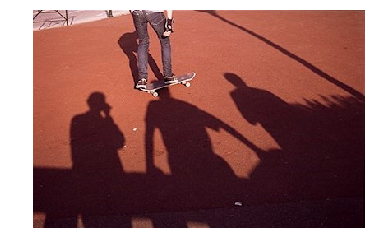

In [7]:
# load and display QA annotations for given question types
"""
All possible quesTypes for abstract and mscoco has been provided in respective text files in ../QuestionTypes/ folder.
"""
annIds = vqa_train.getQuesIds(quesTypes='how many');   
anns = vqa_train.loadQA(annIds)
randomAnn = random.choice(anns)
vqa_train.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType_train + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir_train + imgFilename):
    I = io.imread(imgDir_train + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()
else: print(imgDir_train + imgFilename)

Question: Is the glass full of water?
Answer 1: no
Answer 2: no
Answer 3: no
Answer 4: no
Answer 5: no
Answer 6: no
Answer 7: no
Answer 8: no
Answer 9: no
Answer 10: no


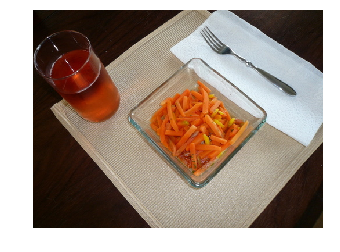

In [8]:
# load and display QA annotations for given answer types
"""
ansTypes can be one of the following
yes/no
number
other
"""
annIds = vqa_train.getQuesIds(ansTypes='yes/no');   
anns = vqa_train.loadQA(annIds)
randomAnn = random.choice(anns)
vqa_train.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType_train + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir_train + imgFilename):
    I = io.imread(imgDir_train + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

Question: What shape is the lamp in the room?
Answer 1: no lamp
Answer 2: square
Answer 3: circle
Answer 4: round
Answer 5: round
Answer 6: round
Answer 7: circle
Answer 8: sphere
Answer 9: round
Answer 10: round


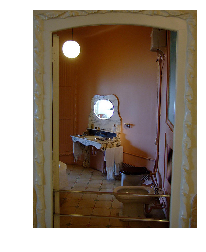

In [9]:
# load and display QA annotations for given images
"""
Usage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])
Above method can be used to retrieve imageIds for given question Ids or given question types or given answer types.
"""
ids = vqa_train.getImgIds()
annIds = vqa_train.getQuesIds(imgIds=random.sample(ids, 5));
anns = vqa_train.loadQA(annIds)
randomAnn = random.choice(anns)
vqa_train.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType_train + '_' + str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir_train + imgFilename):
    I = io.imread(imgDir_train + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

Question: Which wrist has a sweatband?
Answer 1: right
Answer 2: her right
Answer 3: right
Answer 4: right
Answer 5: right
Answer 6: right
Answer 7: right
Answer 8: right wrist
Answer 9: right
Answer 10: right


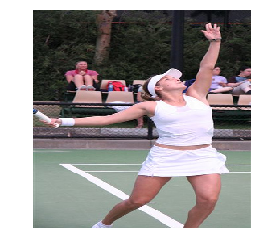

In [10]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)
randomAnn = random.choice(anns)
vqa_train.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType_train + '_' + str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir_train + imgFilename):
    '''
    I = io.imread(imgDir_train + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()
    
    '''
    img = image.load_img(imgDir_train + imgFilename, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [11]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)
anns = shuffle(anns, random_state=0)
num_batches = len(anns) // batch_size + (1 if len(anns) % batch_size > 0 else 0)

#print num_batches
i = 2
anns_batch = anns[i * batch_size : min((i + 1) * batch_size, len(anns))]
#print len(anns_batch)

ann = anns_batch[0]
print ann
print vqa_train.qqa[ann['question_id']]['question']

question = nlp(vqa_train.qqa[ann['question_id']]['question'])
for w in question:
    print (w.text, w.pos_, len(w.vector))
    
question_word_vec = [w.vector for w in question]

{u'question_type': u'are the', u'multiple_choice_answer': u'no', u'answers': [{u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 1}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 2}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 3}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 4}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 5}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 6}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 7}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 8}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 9}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 10}], u'image_id': 363205, u'answer_type': u'yes/no', u'question_id': 3632051}
Are the planes in flight?
(u'Are', u'VERB', 300)
(u'the', u'DET', 300)
(u'planes', u'NOUN', 300)
(u'in', u'ADP', 300)
(u'flight', u'NOUN', 300)
(u'?', u'PUNCT', 300)


## Process data

In [19]:
ans_types=[]
#ans_types='yes/no'

Modify the call to get_most_common_answers to 1000 or 3000 depending on the model used

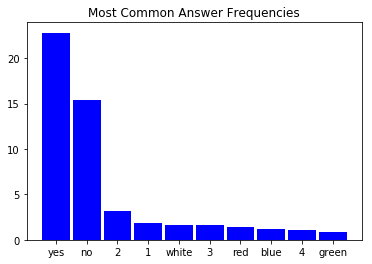

In [20]:
def get_most_common_answers(num_answers):
    ans_dict = {}
    annIds = vqa_train.getQuesIds(ansTypes=ans_types)
    anns = vqa_train.loadQA(annIds)
    for ann in anns:
        for ans in ann['answers']:
            answer = ans['answer'].lower()
            if answer in ans_dict:
                ans_dict[answer] += 1
            else:
                ans_dict[answer] = 1
        '''
        if ann['multiple_choice_answer'] in ans_dict:
            ans_dict[ann['multiple_choice_answer']] += 1
        else:
            ans_dict[ann['multiple_choice_answer']] = 1
        '''
    sorted_ans_dict = sorted(ans_dict.items(), key=itemgetter(1), reverse=True)
    
    # Some bar plots
    num_ans_plot = 10
    total_ans = 0
    for (x,y) in sorted_ans_dict: total_ans += y
    plt.bar(range(1, num_ans_plot+1), [float(y) / total_ans * 100 for (x,y) in sorted_ans_dict[0:num_ans_plot]], 0.9, color='b')
    plt.xticks(range(1, num_ans_plot+1), [x for (x,y) in sorted_ans_dict[0:num_ans_plot]])
    plt.title("Most Common Answer Frequencies")
    plt.show()
    
    sorted_ans_dict = [x for (x,y) in sorted_ans_dict]
    sorted_ans_dict = sorted_ans_dict[0:num_answers]

    ans_to_id = dict((a, i) for i, a in enumerate(sorted_ans_dict))
    id_to_ans = dict((i, a) for i, a in enumerate(sorted_ans_dict))
    return ans_to_id, id_to_ans

ans_to_id, id_to_ans = get_most_common_answers(1000)

In [9]:
def process_question(vqa, ann):
    quesId = ann['question_id']
    if quesId in question_word_vec_map:
        return question_word_vec_map[quesId]
    question = nlp(vqa.qqa[quesId]['question'])
    question_word_vec = [w.vector for w in question]

    return np.array(question_word_vec)

In [10]:
def process_answer(vqa, ann):
    quesId = ann['question_id']
    if quesId in ans_map:
        return ans_map[quesId]
    answer = ann['multiple_choice_answer'].lower() 
    if answer in ans_to_id:
        encoding = np.zeros(len(id_to_ans))
        encoding[ans_to_id[answer]] = 1
        return encoding
    else:
        return None

In [11]:
# VGG 19 post-convolution layers
model = VGG19(weights='imagenet', include_top=False)

def process_img(vqa, ann, dataSubType, imgDir):
    imgId = ann['image_id']
    imgFilename = 'COCO_' + dataSubType + '_' + str(imgId).zfill(12) + '.jpg'
    if os.path.isfile(imgDir + imgFilename):
        img = image.load_img(imgDir + imgFilename, target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        features = model.predict(np.array([x]))
        features = np.reshape(features[0], (512, 49))
        return features
    else:
        return None

In [11]:
# VGG 19 fc2 layer
base_model = VGG19(weights='imagenet', include_top=True)
model = Model(input=base_model.input, output=base_model.get_layer('fc2').output)

def process_img(vqa, ann, dataSubType, imgDir):   
    imgId = ann['image_id']
    imgFilename = 'COCO_' + dataSubType + '_' + str(imgId).zfill(12) + '.jpg'
    if os.path.isfile(imgDir + imgFilename):
        img = image.load_img(imgDir + imgFilename, target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        features = model.predict(np.array([x]))
        features = np.reshape(features[0], (4096,))
        features /= LA.norm(features, 2)
        return features
    else:
        return None

/home/crisojog/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fc..., inputs=Tensor("in...)`
  app.launch_new_instance()


In [12]:
# ResNet50 
model = ResNet50(weights='imagenet', include_top=False)

def process_img(vqa, ann, dataSubType, imgDir):   
    imgId = ann['image_id']
    imgFilename = 'COCO_' + dataSubType + '_' + str(imgId).zfill(12) + '.jpg'
    if os.path.isfile(imgDir + imgFilename):
        img = image.load_img(imgDir + imgFilename, target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        features = model.predict(np.array([x]))
        features = np.reshape(features[0], (2048,))
        features /= LA.norm(features, 2)
        return features
    else:
        return None

In [13]:
question_word_vec_map = {}
ans_map = {}
img_map = {}
ques_to_img = {}

In [14]:
annIds = vqa_train.getQuesIds(ansTypes=ans_types)
anns = vqa_train.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    if quesId in question_word_vec_map: 
        continue

    question = process_question(vqa_train, ann)
    if question is None: 
        continue
    
    question_word_vec_map[quesId] = question

100%|██████████| 95302/95302 [00:22<00:00, 4186.48it/s]


In [16]:
f = open("data/train_questions.pkl", "w")
pickle.dump(question_word_vec_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [17]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    if quesId in ans_map: 
        continue

    answer = process_answer(vqa_train, ann)
    if answer is None: 
        continue

    ans_map[quesId] = answer.tolist()

100%|██████████| 95302/95302 [00:02<00:00, 36277.04it/s]


In [18]:
f = open("data/train_answers.pkl", "w")
pickle.dump(ans_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [36]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)

for ann in tqdm(anns):
    imgId = int(ann['image_id'])
    if imgId in img_map:
        continue
        
    img = process_img(vqa_train, ann, dataSubType_train, imgDir_train)
    if img is None: 
        continue

    img_map[imgId] = img

100%|██████████| 248349/248349 [22:47<00:00, 181.55it/s]


In [37]:
f = open("data/train_images.pkl", "w")
pickle.dump(img_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [16]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    imgId = int(ann['image_id'])
    ques_to_img[quesId] = imgId

100%|██████████| 248349/248349 [00:00<00:00, 705176.32it/s]


In [17]:
f = open("data/train_ques_to_img.pkl", "w")
pickle.dump(ques_to_img, f, pickle.HIGHEST_PROTOCOL)
f.close()

Now for the validation set

In [69]:
question_word_vec_map = {}
ans_map = {}
img_map = {}
ques_to_img = {}

In [50]:
annIds = vqa_val.getQuesIds()
anns = vqa_val.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    if quesId in question_word_vec_map: 
        continue

    question = process_question(vqa_val, ann)
    if question is None: 
        continue
    
    question_word_vec_map[quesId] = question

100%|██████████| 121512/121512 [00:35<00:00, 3422.20it/s]


In [51]:
f = open("data/val_questions.pkl", "w")
pickle.dump(question_word_vec_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [70]:
annIds = vqa_val.getQuesIds()
anns = vqa_val.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    if quesId in ans_map: 
        continue

    answer = process_answer(vqa_val, ann)
    if answer is None: 
        continue

    ans_map[quesId] = answer

100%|██████████| 121512/121512 [00:00<00:00, 357149.65it/s]


In [71]:
f = open("data/val_answers.pkl", "w")
pickle.dump(ans_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [39]:
annIds = vqa_val.getQuesIds()
anns = vqa_val.loadQA(annIds)

for ann in tqdm(anns):
    imgId = int(ann['image_id'])
    if imgId in img_map:
        continue
        
    img = process_img(vqa_val, ann, dataSubType_val, imgDir_val)
    if img is None: 
        continue

    img_map[imgId] = img

100%|██████████| 121512/121512 [11:13<00:00, 180.35it/s]


In [40]:
f = open("data/val_images.pkl", "w")
pickle.dump(img_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [23]:
annIds = vqa_val.getQuesIds()
anns = vqa_val.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    imgId = int(ann['image_id'])
    ques_to_img[quesId] = imgId

100%|██████████| 121512/121512 [00:00<00:00, 747107.81it/s]


In [24]:
f = open("data/val_ques_to_img.pkl", "w")
pickle.dump(ques_to_img, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Run these to prepare dataset for training

In [28]:
print "Loading train questions"
ques_train_map = pickle.load(open("data/train_questions.pkl","r"))
print "Loading train answers"
ans_train_map = pickle.load(open("data/train_answers.pkl","r"))
print "Loading train images"
img_train_map = pickle.load(open("data/train_images.pkl","r"))
print "Loading ques_to_img map"
ques_to_img_train = pickle.load(open("data/train_ques_to_img.pkl","r"))
print "Done"

Loading train questions
Loading train answers
Loading train images
Loading ques_to_img map
Done


In [29]:
print "Loading validation questions"
ques_val_map = pickle.load(open("data/val_questions.pkl","r"))
print "Loading validation answers"
ans_val_map = pickle.load(open("data/val_answers.pkl","r"))
print "Loading validation images"
img_val_map = pickle.load(open("data/val_images.pkl","r"))
print "Loading ques_to_img map"
ques_to_img_val = pickle.load(open("data/val_ques_to_img.pkl","r"))
print "Done"

Loading validation questions
Loading validation answers
Loading validation images
Loading ques_to_img map
Done


In [30]:
ques_train_ids = np.array(ques_train_map.keys())
ques_val_ids = np.array(ques_val_map.keys())
train_dim, val_dim = len(ques_train_ids), len(ques_val_ids)
print train_dim, val_dim

248349 121512


### Train model helper functions

In [15]:
def get_batch(batch, batch_size, ques_map, ans_map, img_map, ques_ids, ques_to_img):
    # get ids in the current batch
    batch_ids = ques_ids[batch * batch_size: min((batch + 1) * batch_size, len(ques_ids))]
    # filter out ids which don't have question, answer or image
    batch_ids = [batch_id for batch_id in batch_ids if batch_id in ques_map and batch_id in ans_map and ques_to_img[batch_id] in img_map]

    # add questions to batch
    batch_questions = [ques_map[batch_id] for batch_id in batch_ids]
    batch_answers = [ans_map[batch_id] for batch_id in batch_ids]
    batch_images = [img_map[ques_to_img[batch_id]] for batch_id in batch_ids]

    # find out maximum length of a question in this batch
    max_len = max([len(ques) for ques in batch_questions])
    # ... and pad all questions in the batch to that length (more efficient than padding all questions to a single maximum length)
    batch_ques_aligned = []
    for question in batch_questions:
        if len(question) < max_len:
            batch_ques_aligned.append(np.append(question, np.zeros((max_len - len(question), 300)), axis=0))
        else:
            batch_ques_aligned.append(question)
    # finally, construct train_X, and train_y
    train_X = [np.array(batch_images), np.array(batch_ques_aligned)]
    train_y = np.array(batch_answers)
    return train_X, train_y

In [16]:
def train_epoch(
        epoch_no,
        model,
        num_batches, 
        batch_size, 
        ques_map, 
        ans_map, 
        img_map, 
        ques_ids, 
        ques_to_img):
    # shuffle all question ids on each epoch
    np.random.shuffle(ques_ids)
    
    loss, accuracy, total = .0, .0, .0
    for batch in tqdm(range(num_batches), desc="Train epoch %d" % epoch_no):
        train_X, train_y = get_batch(batch, batch_size, ques_map, ans_map, img_map, ques_ids, ques_to_img)
        total += len(train_y)
        # ... and train model with the batch
        l, a = model.train_on_batch(train_X, train_y)
        loss += l * len(train_y)
        accuracy += a * len(train_y)
    loss /= total
    accuracy /= total
    print("Train loss: {}\tAccuracy: {}".format(loss, accuracy))
    return loss, accuracy

In [17]:
def val_epoch(
        epoch_no,
        model, 
        num_batches, 
        batch_size, 
        ques_map, 
        ans_map, 
        img_map, 
        ques_ids,
        ques_to_img):    
    loss, accuracy, total = .0, .0, .0
    for batch in tqdm(range(num_batches), desc="Val epoch %d" % epoch_no):    
        val_X, val_y = get_batch(batch, batch_size, ques_map, ans_map, img_map, ques_ids, ques_to_img)
        total += len(val_y)
        l, a = model.test_on_batch(val_X, val_y)
        loss += l * len(val_y)
        accuracy += a * len(val_y)
    loss /= total
    accuracy /= total
    print("Val loss: {}\tAccuracy: {}".format(loss, accuracy))
    return loss, accuracy

In [37]:
# constants for evaluation

taskType = 'OpenEnded'
dataType = 'mscoco'  # 'mscoco' for real and 'abstract_v002' for abstract
dataSubType = 'val2014'
annFile = '%s/Annotations/%s_%s_annotations.json' % (dataDir, dataType, dataSubType)
quesFile = '%s/Questions/%s_%s_%s_questions.json' % (dataDir, taskType, dataType, dataSubType)
imgDir = '%s/Images/%s/%s/' % (dataDir, dataType, dataSubType)
resultType = 'eval'
fileTypes = ['results', 'accuracy', 'evalQA', 'evalQuesType', 'evalAnsType']

[resFile, accuracyFile, evalQAFile, evalQuesTypeFile, evalAnsTypeFile] = \
    ['%s/Results/%s_%s_%s_%s_%s.json' % (dataDir, taskType, dataType, dataSubType, \
                                         resultType, fileType) for fileType in fileTypes]

In [41]:
def process_question_batch(questions, question_ids, images, results):
    # find out maximum length of a question in this batch
    max_len = max([len(ques) for ques in questions])
    # ... and pad all questions in the batch to that length (more efficient than padding all questions to a single maximum length)
    ques_aligned = []
    for question in questions:
        if len(question) < max_len:
            ques_aligned.append(np.append(question, np.zeros((max_len - len(question), 300)), axis=0))
        else:
            ques_aligned.append(question)            
    val_X = [np.array(images), np.array(ques_aligned)]

    predicted_y = model.predict_on_batch(val_X)
    # add results to map
    for ans, question_id in zip(predicted_y, question_ids):
        res = {}
        res['question_id'] = int(question_id)
        # Get the best answer via argmax
        res['answer'] = id_to_ans[np.argmax(ans)]
        # Get the best answer via sampling
        # res['answer'] = id_to_ans[np.random.choice(range(len(ans)), p=ans)]
        results.append(res)

def print_accuracies(vqaEval):
    print "\n"
    print "Overall Accuracy is: %.02f\n" % (vqaEval.accuracy['overall'])
    print "Per Question Type Accuracy is the following:"
    for quesType in vqaEval.accuracy['perQuestionType']:
        print "%s : %.02f" % (quesType, vqaEval.accuracy['perQuestionType'][quesType])
    print "\n"
    print "Per Answer Type Accuracy is the following:"
    for ansType in vqaEval.accuracy['perAnswerType']:
        print "%s : %.02f" % (ansType, vqaEval.accuracy['perAnswerType'][ansType])
    print "\n"

def evaluate(
        vqa,
        model, 
        batch_size, 
        ques_map, 
        ans_map, 
        img_map,
        id_to_ans,
        verbose=False):    

    annIds = vqa.getQuesIds();
    anns = vqa.loadQA(annIds)
    
    questions = []
    question_ids = []
    images = []

    results = []
    for ann in tqdm(anns):
        questions.append(ques_map[ann['question_id']])
        question_ids.append(ann['question_id'])
        images.append(img_map[ann['image_id']])
        if len(questions) == batch_size:
            process_question_batch(questions, question_ids, images, results)
            # clear arrays
            questions, question_ids, images = [], [], []
    if len(questions) > 0:
        process_question_batch(questions, question_ids, images, results)
    
    # save results as a json
    with open(resFile,"w") as outfile:
        json.dump(results, outfile)
    
    # create vqa object and vqaRes object
    vqa_ann = VQA(annFile, quesFile)
    vqaRes = vqa_ann.loadRes(resFile, quesFile)

    # create vqaEval object by taking vqa and vqaRes
    vqaEval = VQAEval(vqa_ann, vqaRes, n=2)  # n is precision of accuracy (number of places after decimal), default is 2
    
    vqaEval.evaluate()
    
    if verbose:
        print_accuracies(vqaEval)
    
    return vqaEval.accuracy['overall']

### Model 1

In [23]:
def Word2VecModel(embedding_dim, dropout_rate):
    print("Creating text model...")
    model = Sequential()
    model.add(LSTM(units=512, return_sequences=True, input_shape=(None, embedding_dim)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=512, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation='tanh'))
    return model


def img_model(dropout_rate):
    print("Creating image model...")
    model = Sequential()
    model.add(Dense(1024, input_dim=2048, activation='tanh'))
    return model


def vqa_model(embedding_dim, dropout_rate, num_classes):
    vgg_model = img_model(dropout_rate)
    lstm_model = Word2VecModel(embedding_dim, dropout_rate)
    print("Merging final model...")
    fc_model = Sequential()
    fc_model.add(Merge([vgg_model, lstm_model], mode='mul'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(1000, activation='tanh'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(num_classes, activation='softmax'))
    fc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                     metrics=['accuracy'])
    return fc_model

In [31]:
# model parameters
dropout_rate = 0.5
embedding_size = 300
num_classes = 1000

# training parameters
num_epochs = 80
batch_size = 1000
num_batches_train = train_dim // batch_size
num_batches_val = val_dim // batch_size
eval_every = 5

train_loss, train_acc = [], []
val_loss, val_acc = [], []
eval_acc = []

In [32]:
model = vqa_model(embedding_size, dropout_rate, num_classes)

Creating image model...
Creating text model...
Merging final model...


/home/crisojog/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [17]:
model.load_weights("models/model_1_weights.h5")

In [82]:
for k in range(num_epochs):
    loss, acc = train_epoch(k + 1, model, num_batches_train, batch_size, ques_train_map, ans_train_map, img_train_map, ques_train_ids, ques_to_img_train)
    train_loss.append(loss)
    train_acc.append(acc)
    loss, acc = val_epoch(k + 1, model, num_batches_val, batch_size, ques_val_map, ans_val_map, img_val_map, ques_val_ids, ques_to_img_val)
    val_loss.append(loss)
    val_acc.append(acc)
    if (k + 1) % eval_every == 0:
        model.save_weights("models/model_1/model_1_epoch_%d_weights.h5" % (k + 1), overwrite=True)
        eval_accuracy = evaluate(vqa_val, model, batch_size, ques_val_map, ans_val_map, img_val_map, id_to_ans)
        print ("Eval accuracy: %.2f" % eval_accuracy)
        eval_acc.append(eval_accuracy)

Val epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

Train loss: 4.05944280661	Accuracy: 0.260492389492


Train epoch 2:   0%|          | 1/248 [00:00<00:39,  6.26it/s]

Val loss: 3.42488617125	Accuracy: 0.292555856857


Val epoch 2:   2%|▏         | 2/121 [00:00<00:08, 13.78it/s]

Train loss: 2.80103158226	Accuracy: 0.358273410468


Train epoch 3:   0%|          | 1/248 [00:00<00:39,  6.30it/s]

Val loss: 2.49801599856	Accuracy: 0.398043447128


Val epoch 3:   2%|▏         | 2/121 [00:00<00:08, 14.08it/s]

Train loss: 2.31662347899	Accuracy: 0.400601378729


Train epoch 4:   0%|          | 1/248 [00:00<00:34,  7.10it/s]

Val loss: 2.1383344187	Accuracy: 0.425172691669


Val epoch 4:   2%|▏         | 2/121 [00:00<00:08, 14.17it/s]

Train loss: 2.09677186149	Accuracy: 0.425243130114


Train epoch 5:   0%|          | 1/248 [00:00<00:37,  6.56it/s]

Val loss: 1.97916948555	Accuracy: 0.444043525835


Val epoch 5:   2%|▏         | 2/121 [00:00<00:08, 14.12it/s]

Train loss: 1.96600559018	Accuracy: 0.443478462094


Val epoch 5: 100%|██████████| 121/121 [00:08<00:00, 14.64it/s]


Val loss: 1.90027032548	Accuracy: 0.456064517412


100%|██████████| 121512/121512 [00:10<00:00, 12125.15it/s]


loading VQA annotations and questions into memory...
0:00:07.157646
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 6:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 45.89


Val epoch 6:   2%|▏         | 2/121 [00:00<00:08, 13.50it/s]

Train loss: 1.87230867196	Accuracy: 0.455628702275


Train epoch 7:   0%|          | 1/248 [00:00<00:39,  6.29it/s]

Val loss: 1.82292437111	Accuracy: 0.462962603672


Val epoch 7:   2%|▏         | 2/121 [00:00<00:09, 12.29it/s]

Train loss: 1.79794274806	Accuracy: 0.47044375775


Train epoch 8:   0%|          | 1/248 [00:00<00:46,  5.31it/s]

Val loss: 1.75724324808	Accuracy: 0.481872028694


Val epoch 8:   2%|▏         | 2/121 [00:00<00:08, 13.25it/s]

Train loss: 1.73590300704	Accuracy: 0.488369267181


Train epoch 9:   0%|          | 1/248 [00:00<00:38,  6.43it/s]

Val loss: 1.77699565672	Accuracy: 0.474337199287


Val epoch 9:   2%|▏         | 2/121 [00:00<00:08, 13.70it/s]

Train loss: 1.6829610652	Accuracy: 0.499726872915


Train epoch 10:   0%|          | 1/248 [00:00<00:37,  6.52it/s]

Val loss: 1.67442131442	Accuracy: 0.505971903487


Val epoch 10:   2%|▏         | 2/121 [00:00<00:09, 12.64it/s]

Train loss: 1.63766032999	Accuracy: 0.511894474503


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.66686773379	Accuracy: 0.50892409052


100%|██████████| 121512/121512 [00:10<00:00, 12149.84it/s]


loading VQA annotations and questions into memory...
0:00:05.536241
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 11:   0%|          | 1/248 [00:00<00:42,  5.78it/s]

Done computing accuracy
Eval accuracy: 50.64


Val epoch 11:   2%|▏         | 2/121 [00:00<00:08, 13.67it/s]

Train loss: 1.591899768	Accuracy: 0.524434541743


Train epoch 12:   0%|          | 1/248 [00:00<00:41,  6.01it/s]

Val loss: 1.65290487071	Accuracy: 0.507949677868


Val epoch 12:   2%|▏         | 2/121 [00:00<00:08, 13.61it/s]

Train loss: 1.55316540228	Accuracy: 0.535698941062


Train epoch 13:   0%|          | 1/248 [00:00<00:38,  6.41it/s]

Val loss: 1.60065435473	Accuracy: 0.523810440494


Val epoch 13:   2%|▏         | 2/121 [00:00<00:08, 13.61it/s]

Train loss: 1.51745074069	Accuracy: 0.543332298617


Train epoch 14:   0%|          | 1/248 [00:00<00:38,  6.34it/s]

Val loss: 1.59616533623	Accuracy: 0.53131632782


Val epoch 14:   2%|▏         | 2/121 [00:00<00:09, 13.07it/s]

Train loss: 1.48554214715	Accuracy: 0.551860181896


Train epoch 15:   0%|          | 1/248 [00:00<00:38,  6.50it/s]

Val loss: 1.58160729826	Accuracy: 0.534104497673


Val epoch 15:   2%|▏         | 2/121 [00:00<00:08, 13.51it/s]

Train loss: 1.45524724157	Accuracy: 0.561444216598


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.58229676667	Accuracy: 0.530399798211


100%|██████████| 121512/121512 [00:09<00:00, 12338.59it/s]


loading VQA annotations and questions into memory...
0:00:05.346543
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 16:   0%|          | 1/248 [00:00<00:46,  5.26it/s]

Done computing accuracy
Eval accuracy: 52.43


Val epoch 16:   2%|▏         | 2/121 [00:00<00:09, 12.58it/s]

Train loss: 1.42758308615	Accuracy: 0.568803952126


Train epoch 17:   0%|          | 1/248 [00:00<00:35,  6.86it/s]

Val loss: 1.56446132464	Accuracy: 0.536333109419


Val epoch 17:   2%|▏         | 2/121 [00:00<00:08, 13.49it/s]

Train loss: 1.40034489092	Accuracy: 0.577226203202


Train epoch 18:   0%|          | 1/248 [00:00<00:38,  6.49it/s]

Val loss: 1.57256191656	Accuracy: 0.53387295423


Val epoch 18:   2%|▏         | 2/121 [00:00<00:08, 13.53it/s]

Train loss: 1.37424475035	Accuracy: 0.583755464043


Train epoch 19:   0%|          | 1/248 [00:00<00:38,  6.36it/s]

Val loss: 1.56226476121	Accuracy: 0.543491679417


Val epoch 19:   2%|▏         | 2/121 [00:00<00:08, 13.63it/s]

Train loss: 1.34545201594	Accuracy: 0.592171176277


Train epoch 20:   0%|          | 1/248 [00:00<00:36,  6.78it/s]

Val loss: 1.54633877942	Accuracy: 0.547360395066


Val epoch 20:   2%|▏         | 2/121 [00:00<00:08, 13.22it/s]

Train loss: 1.32015055775	Accuracy: 0.601022501436


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.55714488145	Accuracy: 0.547813839235


100%|██████████| 121512/121512 [00:09<00:00, 12291.86it/s]


loading VQA annotations and questions into memory...
0:00:05.536366
creating index...
index created!
Loading and preparing results...     
DONE (t=0.39s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 21:   0%|          | 1/248 [00:00<00:45,  5.40it/s]

Done computing accuracy
Eval accuracy: 54.12


Val epoch 21:   2%|▏         | 2/121 [00:00<00:08, 13.48it/s]

Train loss: 1.29933950899	Accuracy: 0.608491417644


Train epoch 22:   0%|          | 1/248 [00:00<00:34,  7.07it/s]

Val loss: 1.55406175644	Accuracy: 0.550312580938


Val epoch 22:   2%|▏         | 2/121 [00:00<00:08, 13.27it/s]

Train loss: 1.27460511961	Accuracy: 0.616200991359


Train epoch 23:   0%|          | 1/248 [00:00<00:38,  6.40it/s]

Val loss: 1.57090027687	Accuracy: 0.547765599828


Val epoch 23:   2%|▏         | 2/121 [00:00<00:08, 13.53it/s]

Train loss: 1.25021595797	Accuracy: 0.623837953911


Train epoch 24:   0%|          | 1/248 [00:00<00:42,  5.77it/s]

Val loss: 1.57328243164	Accuracy: 0.551296646852


Val epoch 24:   2%|▏         | 2/121 [00:00<00:08, 13.50it/s]

Train loss: 1.22751873311	Accuracy: 0.63220386696


Train epoch 25:   0%|          | 1/248 [00:00<00:38,  6.49it/s]

Val loss: 1.59382942741	Accuracy: 0.549289926801


Val epoch 25:   2%|▏         | 2/121 [00:00<00:09, 13.12it/s]

Train loss: 1.2024803527	Accuracy: 0.639869636287


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.62902189967	Accuracy: 0.55128699342


100%|██████████| 121512/121512 [00:10<00:00, 12014.01it/s]


loading VQA annotations and questions into memory...
0:00:05.310349
creating index...
index created!
Loading and preparing results...     
DONE (t=0.39s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 26:   0%|          | 1/248 [00:00<00:44,  5.58it/s]

Done computing accuracy
Eval accuracy: 54.38


Val epoch 26:   2%|▏         | 2/121 [00:00<00:08, 13.51it/s]

Train loss: 1.18284490487	Accuracy: 0.647774274518


Train epoch 27:   0%|          | 1/248 [00:00<00:38,  6.43it/s]

Val loss: 1.608594674	Accuracy: 0.551296639323


Val epoch 27:   2%|▏         | 2/121 [00:00<00:08, 13.46it/s]

Train loss: 1.15797579083	Accuracy: 0.654183215514


Train epoch 28:   0%|          | 1/248 [00:00<00:39,  6.25it/s]

Val loss: 1.5899887889	Accuracy: 0.54805502825


Val epoch 28:   2%|▏         | 2/121 [00:00<00:08, 13.29it/s]

Train loss: 1.1372301147	Accuracy: 0.66189159136


Train epoch 29:   0%|          | 1/248 [00:00<00:42,  5.79it/s]

Val loss: 1.62496375499	Accuracy: 0.55009068906


Val epoch 29:   2%|▏         | 2/121 [00:00<00:08, 13.42it/s]

Train loss: 1.11391328392	Accuracy: 0.66832584157


Train epoch 30:   0%|          | 1/248 [00:00<00:40,  6.04it/s]

Val loss: 1.63420809658	Accuracy: 0.551383472648


Val epoch 30:   2%|▏         | 2/121 [00:00<00:09, 13.09it/s]

Train loss: 1.09529898707	Accuracy: 0.675291806841


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.68161756292	Accuracy: 0.543607450876


100%|██████████| 121512/121512 [00:10<00:00, 12043.94it/s]


loading VQA annotations and questions into memory...
0:00:05.460968
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 31:   0%|          | 1/248 [00:00<00:39,  6.24it/s]

Done computing accuracy
Eval accuracy: 54.02


Val epoch 31:   2%|▏         | 2/121 [00:00<00:08, 13.50it/s]

Train loss: 1.07484273477	Accuracy: 0.68118742913


Train epoch 32:   0%|          | 1/248 [00:00<00:39,  6.25it/s]

Val loss: 1.70789107331	Accuracy: 0.549193453265


Val epoch 32:   2%|▏         | 2/121 [00:00<00:09, 13.20it/s]

Train loss: 1.05489120335	Accuracy: 0.688086537199


Train epoch 33:   0%|          | 1/248 [00:00<00:34,  7.15it/s]

Val loss: 1.69272440704	Accuracy: 0.555859992525


Val epoch 33:   2%|▏         | 2/121 [00:00<00:09, 13.18it/s]

Train loss: 1.03679698449	Accuracy: 0.692545078805


Train epoch 34:   0%|          | 1/248 [00:00<00:42,  5.85it/s]

Val loss: 1.70252685571	Accuracy: 0.553197232397


Val epoch 34:   2%|▏         | 2/121 [00:00<00:08, 13.53it/s]

Train loss: 1.02141872733	Accuracy: 0.698574993648


Train epoch 35:   0%|          | 1/248 [00:00<00:38,  6.45it/s]

Val loss: 1.71752843451	Accuracy: 0.555049591672


Val epoch 35:   2%|▏         | 2/121 [00:00<00:08, 13.48it/s]

Train loss: 1.002425922	Accuracy: 0.703383768171


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.73974581056	Accuracy: 0.554625087102


100%|██████████| 121512/121512 [00:10<00:00, 12137.09it/s]


loading VQA annotations and questions into memory...
0:00:05.170926
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 36:   0%|          | 1/248 [00:00<00:44,  5.58it/s]

Done computing accuracy
Eval accuracy: 54.67


Val epoch 36:   2%|▏         | 2/121 [00:00<00:08, 13.56it/s]

Train loss: 0.984809390785	Accuracy: 0.709263232992


Train epoch 37:   0%|          | 1/248 [00:00<00:37,  6.58it/s]

Val loss: 1.73897750333	Accuracy: 0.55355419275


Val epoch 37:   2%|▏         | 2/121 [00:00<00:08, 13.66it/s]

Train loss: 0.971621786936	Accuracy: 0.713004978443


Train epoch 38:   0%|          | 1/248 [00:00<00:40,  6.04it/s]

Val loss: 1.77109485088	Accuracy: 0.555676684689


Val epoch 38:   2%|▏         | 2/121 [00:00<00:08, 13.30it/s]

Train loss: 0.957724652553	Accuracy: 0.717820963049


Train epoch 39:   0%|          | 1/248 [00:00<00:37,  6.65it/s]

Val loss: 1.8228439547	Accuracy: 0.553091114256


Val epoch 39:   2%|▏         | 2/121 [00:00<00:08, 13.44it/s]

Train loss: 0.941104370612	Accuracy: 0.722702605728


Train epoch 40:   0%|          | 1/248 [00:00<00:36,  6.81it/s]

Val loss: 1.75499650134	Accuracy: 0.551393123759


Val epoch 40:   2%|▏         | 2/121 [00:00<00:08, 13.51it/s]

Train loss: 0.926410718151	Accuracy: 0.727165326158


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.80221554082	Accuracy: 0.554268125416


100%|██████████| 121512/121512 [00:09<00:00, 12275.00it/s]


loading VQA annotations and questions into memory...
0:00:02.350464
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 41:   0%|          | 1/248 [00:00<00:42,  5.85it/s]

Done computing accuracy
Eval accuracy: 54.70


Val epoch 41:   2%|▏         | 2/121 [00:00<00:08, 13.55it/s]

Train loss: 0.914492674903	Accuracy: 0.730674040091


Train epoch 42:   0%|          | 1/248 [00:00<00:39,  6.26it/s]

Val loss: 1.8738208804	Accuracy: 0.552599081446


Val epoch 42:   2%|▏         | 2/121 [00:00<00:08, 13.39it/s]

Train loss: 0.899766800611	Accuracy: 0.734690156466


Train epoch 43:   0%|          | 1/248 [00:00<00:36,  6.70it/s]

Val loss: 1.87372988228	Accuracy: 0.54914521595


Val epoch 43:   2%|▏         | 2/121 [00:00<00:09, 13.13it/s]

Train loss: 0.884865529616	Accuracy: 0.738803589929


Train epoch 44:   0%|          | 1/248 [00:00<00:38,  6.37it/s]

Val loss: 1.90520021786	Accuracy: 0.554731216446


Val epoch 44:   2%|▏         | 2/121 [00:00<00:09, 13.17it/s]

Train loss: 0.872647632519	Accuracy: 0.743187583377


Train epoch 45:   0%|          | 1/248 [00:00<00:32,  7.60it/s]

Val loss: 1.86135450544	Accuracy: 0.548768956485


Val epoch 45:   2%|▏         | 2/121 [00:00<00:08, 13.42it/s]

Train loss: 0.860999497569	Accuracy: 0.746011354562


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.91092805792	Accuracy: 0.55405587334


100%|██████████| 121512/121512 [00:10<00:00, 12106.82it/s]


loading VQA annotations and questions into memory...
0:00:05.216326
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 46:   0%|          | 1/248 [00:00<00:38,  6.38it/s]

Done computing accuracy
Eval accuracy: 54.75


Val epoch 46:   2%|▏         | 2/121 [00:00<00:08, 13.25it/s]

Train loss: 0.850291934822	Accuracy: 0.749238908563


Train epoch 47:   0%|          | 1/248 [00:00<00:37,  6.59it/s]

Val loss: 1.89376831123	Accuracy: 0.552927097467


Val epoch 47:   2%|▏         | 2/121 [00:00<00:08, 13.58it/s]

Train loss: 0.837011841756	Accuracy: 0.753331453272


Train epoch 48:   0%|          | 1/248 [00:00<00:36,  6.70it/s]

Val loss: 1.96694804339	Accuracy: 0.548228690311


Val epoch 48:   2%|▏         | 2/121 [00:00<00:08, 13.64it/s]

Train loss: 0.823708152524	Accuracy: 0.757905145337


Train epoch 49:   0%|          | 1/248 [00:00<00:36,  6.77it/s]

Val loss: 1.95219387993	Accuracy: 0.549646893791


Val epoch 49:   2%|▏         | 2/121 [00:00<00:08, 13.56it/s]

Train loss: 0.812218239334	Accuracy: 0.760501095178


Train epoch 50:   0%|          | 1/248 [00:00<00:36,  6.79it/s]

Val loss: 1.96613517833	Accuracy: 0.552492952459


Val epoch 50:   2%|▏         | 2/121 [00:00<00:08, 13.59it/s]

Train loss: 0.802368775815	Accuracy: 0.764148601105


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 1.90253512836	Accuracy: 0.549743367493


100%|██████████| 121512/121512 [00:09<00:00, 12295.08it/s]


loading VQA annotations and questions into memory...
0:00:02.323304
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 51:   0%|          | 1/248 [00:00<00:42,  5.85it/s]

Done computing accuracy
Eval accuracy: 54.28


Val epoch 51:   2%|▏         | 2/121 [00:00<00:08, 13.28it/s]

Train loss: 0.793221237761	Accuracy: 0.766727046479


Train epoch 52:   0%|          | 1/248 [00:00<00:34,  7.21it/s]

Val loss: 1.97007519403	Accuracy: 0.546665759958


Val epoch 52:   2%|▏         | 2/121 [00:00<00:08, 13.49it/s]

Train loss: 0.782473131053	Accuracy: 0.770028472317


Train epoch 53:   0%|          | 1/248 [00:00<00:39,  6.28it/s]

Val loss: 1.97605713872	Accuracy: 0.548952259501


Val epoch 53:   2%|▏         | 2/121 [00:00<00:08, 13.62it/s]

Train loss: 0.770823525394	Accuracy: 0.772378140453


Train epoch 54:   0%|          | 1/248 [00:00<00:40,  6.03it/s]

Val loss: 2.03611295409	Accuracy: 0.552039511496


Val epoch 54:   2%|▏         | 2/121 [00:00<00:08, 13.61it/s]

Train loss: 0.76178340295	Accuracy: 0.775670466424


Train epoch 55:   0%|          | 1/248 [00:00<00:37,  6.67it/s]

Val loss: 2.06366645048	Accuracy: 0.546453512549


Val epoch 55:   2%|▏         | 2/121 [00:00<00:08, 13.63it/s]

Train loss: 0.747196638257	Accuracy: 0.780259945156


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.05689066588	Accuracy: 0.550013499409


100%|██████████| 121512/121512 [00:09<00:00, 12305.44it/s]


loading VQA annotations and questions into memory...
0:00:05.169243
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 56:   0%|          | 1/248 [00:00<00:35,  6.87it/s]

Done computing accuracy
Eval accuracy: 54.36


Val epoch 56:   2%|▏         | 2/121 [00:00<00:08, 13.45it/s]

Train loss: 0.738476575766	Accuracy: 0.782617618933


Train epoch 57:   0%|          | 1/248 [00:00<00:36,  6.80it/s]

Val loss: 2.11753955465	Accuracy: 0.551547482488


Val epoch 57:   2%|▏         | 2/121 [00:00<00:08, 13.66it/s]

Train loss: 0.729724029044	Accuracy: 0.785693602156


Train epoch 58:   0%|          | 1/248 [00:00<00:36,  6.77it/s]

Val loss: 2.0754475025	Accuracy: 0.553824335357


Val epoch 58:   2%|▏         | 2/121 [00:00<00:08, 13.64it/s]

Train loss: 0.71931304883	Accuracy: 0.788104881321


Train epoch 59:   0%|          | 1/248 [00:00<00:33,  7.30it/s]

Val loss: 2.12865103886	Accuracy: 0.548141854578


Val epoch 59:   2%|▏         | 2/121 [00:00<00:08, 13.51it/s]

Train loss: 0.713091784576	Accuracy: 0.79130344373


Train epoch 60:   0%|          | 1/248 [00:00<00:36,  6.73it/s]

Val loss: 2.16971550987	Accuracy: 0.548711072571


Val epoch 60:   2%|▏         | 2/121 [00:00<00:08, 13.46it/s]

Train loss: 0.704230536424	Accuracy: 0.793596758814


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.18705162143	Accuracy: 0.550177515778


100%|██████████| 121512/121512 [00:09<00:00, 12323.44it/s]


loading VQA annotations and questions into memory...
0:00:02.309518
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 61:   0%|          | 1/248 [00:00<00:42,  5.86it/s]

Done computing accuracy
Eval accuracy: 54.30


Val epoch 61:   2%|▏         | 2/121 [00:00<00:08, 13.54it/s]

Train loss: 0.695874931798	Accuracy: 0.796077781989


Train epoch 62:   0%|          | 1/248 [00:00<00:31,  7.72it/s]

Val loss: 2.13901229728	Accuracy: 0.549550417861


Val epoch 62:   2%|▏         | 2/121 [00:00<00:08, 13.43it/s]

Train loss: 0.68664355625	Accuracy: 0.798155708163


Train epoch 63:   0%|          | 1/248 [00:00<00:38,  6.36it/s]

Val loss: 2.20218140557	Accuracy: 0.54727356941


Val epoch 63:   2%|▏         | 2/121 [00:00<00:08, 13.41it/s]

Train loss: 0.67820195872	Accuracy: 0.801310181921


Train epoch 64:   0%|          | 1/248 [00:00<00:41,  6.00it/s]

Val loss: 2.17788360682	Accuracy: 0.549531121345


Val epoch 64:   2%|▏         | 2/121 [00:00<00:08, 13.68it/s]

Train loss: 0.668992573297	Accuracy: 0.80348404257


Train epoch 65:   0%|          | 1/248 [00:00<00:38,  6.38it/s]

Val loss: 2.19089273609	Accuracy: 0.547331448872


Val epoch 65:   2%|▏         | 2/121 [00:00<00:08, 13.49it/s]

Train loss: 0.661034652443	Accuracy: 0.80652886739


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.21446644401	Accuracy: 0.548373396891


100%|██████████| 121512/121512 [00:09<00:00, 12302.83it/s]


loading VQA annotations and questions into memory...
0:00:05.122068
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 66:   0%|          | 1/248 [00:00<00:46,  5.31it/s]

Done computing accuracy
Eval accuracy: 54.14


Val epoch 66:   2%|▏         | 2/121 [00:00<00:08, 13.59it/s]

Train loss: 0.653837554534	Accuracy: 0.809192514413


Train epoch 67:   0%|          | 1/248 [00:00<00:36,  6.76it/s]

Val loss: 2.27387430858	Accuracy: 0.548633887209


Val epoch 67:   2%|▏         | 2/121 [00:00<00:08, 13.54it/s]

Train loss: 0.649867624452	Accuracy: 0.809857963191


Train epoch 68:   0%|          | 1/248 [00:00<00:41,  5.94it/s]

Val loss: 2.27788568941	Accuracy: 0.546945546765


Val epoch 68:   2%|▏         | 2/121 [00:00<00:08, 13.51it/s]

Train loss: 0.63765925596	Accuracy: 0.812875261891


Train epoch 69:   0%|          | 1/248 [00:00<00:36,  6.84it/s]

Val loss: 2.26346385102	Accuracy: 0.549116270882


Val epoch 69:   2%|▏         | 2/121 [00:00<00:08, 13.66it/s]

Train loss: 0.631950504206	Accuracy: 0.815004681275


Train epoch 70:   0%|          | 1/248 [00:00<00:41,  5.99it/s]

Val loss: 2.26715202622	Accuracy: 0.549627596699


Val epoch 70:   2%|▏         | 2/121 [00:00<00:08, 13.53it/s]

Train loss: 0.623922321366	Accuracy: 0.817671629967


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.28039205055	Accuracy: 0.548566353146


100%|██████████| 121512/121512 [00:09<00:00, 12305.16it/s]


loading VQA annotations and questions into memory...
0:00:02.309194
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 71:   0%|          | 1/248 [00:00<00:42,  5.76it/s]

Done computing accuracy
Eval accuracy: 54.13


Val epoch 71:   2%|▏         | 2/121 [00:00<00:08, 13.63it/s]

Train loss: 0.619883343054	Accuracy: 0.819335096166


Train epoch 72:   0%|          | 1/248 [00:00<00:39,  6.21it/s]

Val loss: 2.29285355821	Accuracy: 0.543974066268


Val epoch 72:   2%|▏         | 2/121 [00:00<00:08, 13.50it/s]

Train loss: 0.613833470977	Accuracy: 0.8206224756


Train epoch 73:   0%|          | 1/248 [00:00<00:33,  7.45it/s]

Val loss: 2.33240055704	Accuracy: 0.546424570011


Val epoch 73:   2%|▏         | 2/121 [00:00<00:08, 13.59it/s]

Train loss: 0.605011555187	Accuracy: 0.823776030859


Train epoch 74:   0%|          | 1/248 [00:00<00:35,  6.87it/s]

Val loss: 2.34095026173	Accuracy: 0.549646893729


Val epoch 74:   2%|▏         | 2/121 [00:00<00:09, 12.85it/s]

Train loss: 0.593319012308	Accuracy: 0.826929621595


Train epoch 75:   0%|          | 1/248 [00:00<00:41,  6.01it/s]

Val loss: 2.35134610373	Accuracy: 0.548518113697


Val epoch 75:   2%|▏         | 2/121 [00:00<00:08, 13.30it/s]

Train loss: 0.591808241864	Accuracy: 0.826992740623


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.35417650206	Accuracy: 0.546588578532


100%|██████████| 121512/121512 [00:10<00:00, 11753.47it/s]


loading VQA annotations and questions into memory...
0:00:02.327450
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 76:   0%|          | 1/248 [00:00<00:45,  5.38it/s]

Done computing accuracy
Eval accuracy: 54.02


Val epoch 76:   2%|▏         | 2/121 [00:00<00:09, 13.15it/s]

Train loss: 0.584499703064	Accuracy: 0.830319405414


Train epoch 77:   0%|          | 1/248 [00:00<00:42,  5.86it/s]

Val loss: 2.34606006877	Accuracy: 0.546530696308


Val epoch 77:   2%|▏         | 2/121 [00:00<00:08, 13.41it/s]

Train loss: 0.576353011209	Accuracy: 0.832214250665


Train epoch 78:   0%|          | 1/248 [00:00<00:39,  6.32it/s]

Val loss: 2.38700725574	Accuracy: 0.547283209942


Val epoch 78:   2%|▏         | 2/121 [00:00<00:08, 13.36it/s]

Train loss: 0.572653177793	Accuracy: 0.833565993024


Train epoch 79:   0%|          | 1/248 [00:00<00:35,  7.04it/s]

Val loss: 2.39297113829	Accuracy: 0.543732872267


Val epoch 79:   2%|▏         | 2/121 [00:00<00:08, 13.30it/s]

Train loss: 0.566330634214	Accuracy: 0.834828921289


Train epoch 80:   0%|          | 1/248 [00:00<00:37,  6.65it/s]

Val loss: 2.46508121436	Accuracy: 0.547871722371


Val epoch 80:   2%|▏         | 2/121 [00:00<00:08, 13.26it/s]

Train loss: 0.557180193051	Accuracy: 0.838538420657


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.47196818905	Accuracy: 0.54984949263


100%|██████████| 121512/121512 [00:09<00:00, 12198.56it/s]


loading VQA annotations and questions into memory...
0:00:05.384329
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
Eval accuracy: 54.22


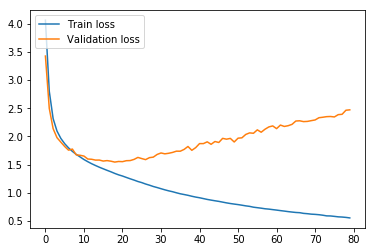

In [83]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

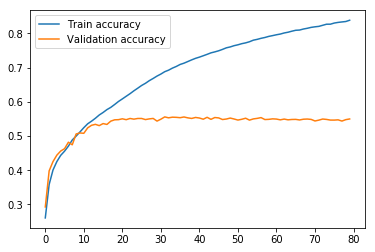

In [84]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

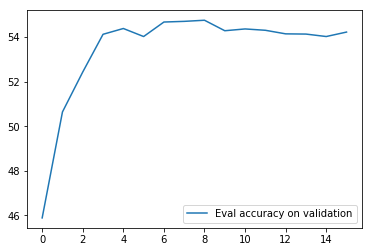

In [85]:
plt.plot(eval_acc)
plt.legend(['Eval accuracy on validation'], loc='lower right')
plt.show()

In [86]:
print "Best accuracy %.02f on epoch %d" % (max(eval_acc), (1 + np.argmax(np.array(eval_acc))) * eval_every)

Best accuracy 54.75 on epoch 45


In [33]:
model.load_weights("models/model_1/model_1_epoch_45_weights.h5")

In [42]:
evaluate(vqa_val, model, batch_size, ques_val_map, ans_val_map, img_val_map, id_to_ans, verbose=True)

100%|██████████| 121512/121512 [00:08<00:00, 13681.17it/s]


loading VQA annotations and questions into memory...
0:00:02.286582
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 54.75

Per Question Type Accuracy is the following:
are there : 82.69
what brand : 35.65
what room is : 88.24
what color is : 53.76
is : 78.00
are they : 76.64
what number is : 5.04
what sport is : 84.72
are : 73.61
is the : 74.55
what is the person : 49.78
how many : 39.26
does this : 78.96
is there a : 87.77
is he : 76.32
what : 35.53
does the : 77.80
is the person : 72.19
where is the : 26.28
what animal is : 58.41
how : 20.37
what is the woman : 41.93
none of the above : 52.63
who is : 22.05
is the woman : 75.16
are the : 73.98
how many people are : 39.34
what is on the : 33.85
has : 76.05
was : 80.15
what type of : 44.36
is this an : 78.95
do : 75.26
what is the man : 50.43
which : 40.44
a

54.75


### Model 2 (same as Model 1 but with 3000 classes of answers)


In [51]:
def Word2VecModel(embedding_dim, dropout_rate):
    print("Creating text model...")
    model = Sequential()
    model.add(LSTM(units=512, return_sequences=True, input_shape=(None, embedding_dim)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=512, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation='tanh'))
    return model


def img_model(dropout_rate):
    print("Creating image model...")
    model = Sequential()
    model.add(Dense(1024, input_dim=2048, activation='tanh'))
    return model


def vqa_model(embedding_dim, dropout_rate, num_classes):
    vgg_model = img_model(dropout_rate)
    lstm_model = Word2VecModel(embedding_dim, dropout_rate)
    print("Merging final model...")
    fc_model = Sequential()
    fc_model.add(Merge([vgg_model, lstm_model], mode='mul'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(1000, activation='tanh'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(num_classes, activation='softmax'))
    
    fc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                     metrics=['accuracy'])
    return fc_model

In [52]:
# model parameters
dropout_rate = 0.5
embedding_size = 300
num_classes = 3000

# training parameters
num_epochs = 80
batch_size = 1000
num_batches_train = train_dim // batch_size
num_batches_val = val_dim // batch_size
eval_every = 5

train_loss, train_acc = [], []
val_loss, val_acc = [], []
eval_acc = []

In [53]:
model = vqa_model(embedding_size, dropout_rate, num_classes)

Creating image model...
Creating text model...
Merging final model...


/home/crisojog/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [60]:
model.load_weights("models/model_2/model_2_epoch_40_weights.h5")

In [54]:
for k in range(num_epochs):
    loss, acc = train_epoch(k + 1, model, num_batches_train, batch_size, ques_train_map, ans_train_map, img_train_map, ques_train_ids, ques_to_img_train)
    train_loss.append(loss)
    train_acc.append(acc)
    loss, acc = val_epoch(k + 1, model, num_batches_val, batch_size, ques_val_map, ans_val_map, img_val_map, ques_val_ids, ques_to_img_val)
    val_loss.append(loss)
    val_acc.append(acc)
    if (k + 1) % eval_every == 0:
        model.save_weights("models/model_2/model_2_epoch_%d_weights.h5" % (k + 1), overwrite=True)
        eval_accuracy = evaluate(vqa_val, model, batch_size, ques_val_map, ans_val_map, img_val_map, id_to_ans)
        print ("Eval accuracy: %.2f" % eval_accuracy)
        eval_acc.append(eval_accuracy)


Train epoch 1:   4%|▍         | 11/248 [00:03<00:58,  4.04it/s]

Val epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

Train loss: 4.63120609931	Accuracy: 0.248260813368


Train epoch 2:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 4.35073931985	Accuracy: 0.250510561344


Val epoch 2:   2%|▏         | 2/121 [00:00<00:11, 10.81it/s]

Train loss: 3.68326743627	Accuracy: 0.299616526447


Train epoch 3:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 3.21741452943	Accuracy: 0.333926732588


Val epoch 3:   2%|▏         | 2/121 [00:00<00:10, 10.91it/s]

Train loss: 3.06997584313	Accuracy: 0.35795084248


Train epoch 4:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.95688622946	Accuracy: 0.374916409111


Val epoch 4:   2%|▏         | 2/121 [00:00<00:10, 10.91it/s]

Train loss: 2.88116958123	Accuracy: 0.376809184901


Train epoch 5:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.68190006834	Accuracy: 0.392474379799


Val epoch 5:   2%|▏         | 2/121 [00:00<00:10, 11.03it/s]

Train loss: 2.64431516722	Accuracy: 0.395437709474


Val epoch 5: 100%|██████████| 121/121 [00:10<00:00, 11.49it/s]


Val loss: 2.51467443767	Accuracy: 0.409047366018


100%|██████████| 121512/121512 [00:11<00:00, 10749.07it/s]


loading VQA annotations and questions into memory...
0:00:09.253312
creating index...
index created!
Loading and preparing results...     
DONE (t=0.33s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 6:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 43.96


Val epoch 6:   2%|▏         | 2/121 [00:00<00:10, 11.27it/s]

Train loss: 2.5044489664	Accuracy: 0.412928838252


Train epoch 7:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.41786690985	Accuracy: 0.427680683948


Val epoch 7:   2%|▏         | 2/121 [00:00<00:10, 11.34it/s]

Train loss: 2.40452182315	Accuracy: 0.426338317272


Train epoch 8:   0%|          | 1/248 [00:00<00:48,  5.13it/s]

Val loss: 2.33345954129	Accuracy: 0.434412893388


Val epoch 8:   2%|▏         | 2/121 [00:00<00:10, 11.15it/s]

Train loss: 2.33085094821	Accuracy: 0.440735621375


Train epoch 9:   0%|          | 1/248 [00:00<00:46,  5.37it/s]

Val loss: 2.25553501785	Accuracy: 0.449729805026


Val epoch 9:   2%|▏         | 2/121 [00:00<00:10, 11.17it/s]

Train loss: 2.26227074191	Accuracy: 0.453006253648


Train epoch 10:   0%|          | 1/248 [00:00<00:42,  5.81it/s]

Val loss: 2.24451278019	Accuracy: 0.451085285474


Val epoch 10:   2%|▏         | 2/121 [00:00<00:10, 10.98it/s]

Train loss: 2.2053828466	Accuracy: 0.465320773186


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.17635983323	Accuracy: 0.468796871707


100%|██████████| 121512/121512 [00:10<00:00, 11253.59it/s]


loading VQA annotations and questions into memory...
0:00:02.305173
creating index...
index created!
Loading and preparing results...     
DONE (t=0.34s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 11:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 49.78


Val epoch 11:   2%|▏         | 2/121 [00:00<00:10, 11.02it/s]

Train loss: 2.15693464065	Accuracy: 0.475003060725


Train epoch 12:   0%|          | 1/248 [00:00<00:47,  5.25it/s]

Val loss: 2.1626952666	Accuracy: 0.45827835866


Val epoch 12:   2%|▏         | 2/121 [00:00<00:10, 10.94it/s]

Train loss: 2.11767972855	Accuracy: 0.480581888861


Train epoch 13:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.13263063956	Accuracy: 0.479993131524


Val epoch 13:   2%|▏         | 2/121 [00:00<00:10, 11.04it/s]

Train loss: 2.07674356879	Accuracy: 0.489018411732


Train epoch 14:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.11850290097	Accuracy: 0.480291335086


Val epoch 14:   2%|▏         | 2/121 [00:00<00:10, 11.05it/s]

Train loss: 2.05028253135	Accuracy: 0.495170506323


Train epoch 15:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.09732272105	Accuracy: 0.484665010117


Val epoch 15:   2%|▏         | 2/121 [00:00<00:10, 10.96it/s]

Train loss: 2.02781797412	Accuracy: 0.500535635879


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.09203280063	Accuracy: 0.487294640987


100%|██████████| 121512/121512 [00:10<00:00, 11241.88it/s]


loading VQA annotations and questions into memory...
0:00:02.321202
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 16:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 51.46


Val epoch 16:   2%|▏         | 2/121 [00:00<00:10, 11.07it/s]

Train loss: 2.00161478597	Accuracy: 0.507548961814


Train epoch 17:   0%|          | 1/248 [00:00<00:48,  5.12it/s]

Val loss: 2.09745944458	Accuracy: 0.481746215004


Val epoch 17:   2%|▏         | 2/121 [00:00<00:10, 11.03it/s]

Train loss: 1.97586355028	Accuracy: 0.515843692244


Train epoch 18:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.07925390881	Accuracy: 0.493340077145


Val epoch 18:   2%|▏         | 2/121 [00:00<00:10, 10.98it/s]

Train loss: 1.94477667697	Accuracy: 0.523838882305


Train epoch 19:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.05107440316	Accuracy: 0.491632173781


Val epoch 19:   2%|▏         | 2/121 [00:00<00:10, 10.98it/s]

Train loss: 1.91997624166	Accuracy: 0.529778043977


Train epoch 20:   0%|          | 1/248 [00:00<00:47,  5.22it/s]

Val loss: 2.06284822759	Accuracy: 0.500072287147


Val epoch 20:   2%|▏         | 2/121 [00:00<00:10, 10.91it/s]

Train loss: 1.89317861398	Accuracy: 0.538624340109


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.07851093009	Accuracy: 0.498174621042


100%|██████████| 121512/121512 [00:10<00:00, 11220.70it/s]


loading VQA annotations and questions into memory...
0:00:02.333873
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy

Train epoch 21:   0%|          | 0/248 [00:00<?, ?it/s]


Eval accuracy: 52.56


Val epoch 21:   2%|▏         | 2/121 [00:00<00:10, 11.06it/s]

Train loss: 1.87211031439	Accuracy: 0.544998602136


Train epoch 22:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.03183822308	Accuracy: 0.500912685638


Val epoch 22:   2%|▏         | 2/121 [00:00<00:10, 10.93it/s]

Train loss: 1.84760280431	Accuracy: 0.552452998574


Train epoch 23:   0%|          | 1/248 [00:00<00:47,  5.19it/s]

Val loss: 2.02420112254	Accuracy: 0.511024559566


Val epoch 23:   2%|▏         | 2/121 [00:00<00:10, 10.94it/s]

Train loss: 1.82881332038	Accuracy: 0.559596323043


Train epoch 24:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.03995490328	Accuracy: 0.51213605254


Val epoch 24:   2%|▏         | 2/121 [00:00<00:10, 10.93it/s]

Train loss: 1.80800166997	Accuracy: 0.567488860933


Train epoch 25:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.05036224939	Accuracy: 0.514051797183


Val epoch 25:   2%|▏         | 2/121 [00:00<00:11, 10.73it/s]

Train loss: 1.7846394632	Accuracy: 0.574178201881


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.06026766139	Accuracy: 0.512425218454


100%|██████████| 121512/121512 [00:10<00:00, 11184.22it/s]


loading VQA annotations and questions into memory...
0:00:02.311889
creating index...
index created!
Loading and preparing results...     
DONE (t=0.34s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 26:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 53.80


Val epoch 26:   2%|▏         | 2/121 [00:00<00:11, 10.78it/s]

Train loss: 1.76594284256	Accuracy: 0.580803838711


Train epoch 27:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.04836442444	Accuracy: 0.513111994871


Val epoch 27:   2%|▏         | 2/121 [00:00<00:10, 10.84it/s]

Train loss: 1.74054560388	Accuracy: 0.589727665938


Train epoch 28:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.06828836496	Accuracy: 0.515425347124


Val epoch 28:   2%|▏         | 2/121 [00:00<00:10, 10.85it/s]

Train loss: 1.72597283751	Accuracy: 0.593873113612


Train epoch 29:   0%|          | 1/248 [00:00<00:47,  5.16it/s]

Val loss: 2.09064315061	Accuracy: 0.516871195337


Val epoch 29:   2%|▏         | 2/121 [00:00<00:11, 10.77it/s]

Train loss: 1.70572832849	Accuracy: 0.600752937124


Train epoch 30:   0%|          | 1/248 [00:00<00:48,  5.14it/s]

Val loss: 2.1209788001	Accuracy: 0.50328929435


Val epoch 30:   2%|▏         | 2/121 [00:00<00:10, 10.84it/s]

Train loss: 1.69055972357	Accuracy: 0.605621366263


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.08813033869	Accuracy: 0.505765302387


100%|██████████| 121512/121512 [00:10<00:00, 11170.35it/s]


loading VQA annotations and questions into memory...
0:00:02.317112
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 31:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 53.43


Val epoch 31:   2%|▏         | 2/121 [00:00<00:10, 10.93it/s]

Train loss: 1.6684851445	Accuracy: 0.613074312147


Train epoch 32:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.08532674886	Accuracy: 0.515597040999


Val epoch 32:   2%|▏         | 2/121 [00:00<00:11, 10.63it/s]

Train loss: 1.65279722244	Accuracy: 0.617334423821


Train epoch 33:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.12376265829	Accuracy: 0.513627079214


Val epoch 33:   2%|▏         | 2/121 [00:00<00:11, 10.68it/s]

Train loss: 1.63683815092	Accuracy: 0.624366503722


Train epoch 34:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.1000763771	Accuracy: 0.515705480663


Val epoch 34:   2%|▏         | 2/121 [00:00<00:11, 10.46it/s]

Train loss: 1.6216725183	Accuracy: 0.627700044707


Train epoch 35:   0%|          | 1/248 [00:00<00:43,  5.67it/s]

Val loss: 2.157185241	Accuracy: 0.514024683243


Val epoch 35:   2%|▏         | 2/121 [00:00<00:11, 10.78it/s]

Train loss: 1.60581485344	Accuracy: 0.632103892372


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.1591102011	Accuracy: 0.516536843129


100%|██████████| 121512/121512 [00:10<00:00, 11168.15it/s]


loading VQA annotations and questions into memory...
0:00:02.323705
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 36:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 54.37


Val epoch 36:   2%|▏         | 2/121 [00:00<00:10, 10.90it/s]

Train loss: 1.59250075543	Accuracy: 0.637169422441


Train epoch 37:   0%|          | 1/248 [00:00<00:43,  5.69it/s]

Val loss: 2.15913339731	Accuracy: 0.514819901467


Val epoch 37:   2%|▏         | 2/121 [00:00<00:11, 10.70it/s]

Train loss: 1.57956859784	Accuracy: 0.640698713817


Train epoch 38:   0%|          | 1/248 [00:00<00:45,  5.37it/s]

Val loss: 2.13931417323	Accuracy: 0.514593985843


Val epoch 38:   2%|▏         | 2/121 [00:00<00:10, 10.91it/s]

Train loss: 1.56520653482	Accuracy: 0.645782497657


Train epoch 39:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.19308875492	Accuracy: 0.513943356025


Val epoch 39:   2%|▏         | 2/121 [00:00<00:11, 10.76it/s]

Train loss: 1.55440406915	Accuracy: 0.649353939208


Train epoch 40:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.21025986053	Accuracy: 0.520765935082


Val epoch 40:   2%|▏         | 2/121 [00:00<00:10, 10.93it/s]

Train loss: 1.53924153388	Accuracy: 0.652769151837


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.24749771072	Accuracy: 0.522410578614


100%|██████████| 121512/121512 [00:10<00:00, 11167.07it/s]


loading VQA annotations and questions into memory...
0:00:02.313304
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 41:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 54.82


Val epoch 41:   2%|▏         | 2/121 [00:00<00:10, 10.88it/s]

Train loss: 1.5248089731	Accuracy: 0.65660677602


Train epoch 42:   0%|          | 1/248 [00:00<00:48,  5.13it/s]

Val loss: 2.23664839927	Accuracy: 0.518271855935


Val epoch 42:   2%|▏         | 2/121 [00:00<00:10, 10.85it/s]

Train loss: 1.51537108916	Accuracy: 0.65921990623


Train epoch 43:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.21772355754	Accuracy: 0.5195008245


Val epoch 43:   2%|▏         | 2/121 [00:00<00:10, 10.93it/s]

Train loss: 1.50359034821	Accuracy: 0.663066523805


Train epoch 44:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.25136540882	Accuracy: 0.517801951681


Val epoch 44:   2%|▏         | 2/121 [00:00<00:10, 10.85it/s]

Train loss: 1.49217665988	Accuracy: 0.66679347522


Train epoch 45:   0%|          | 1/248 [00:00<00:46,  5.35it/s]

Val loss: 2.27795366958	Accuracy: 0.5167898563


Val epoch 45:   2%|▏         | 2/121 [00:00<00:11, 10.75it/s]

Train loss: 1.48098828408	Accuracy: 0.668781559049


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.24382363326	Accuracy: 0.515732593126


100%|██████████| 121512/121512 [00:10<00:00, 11183.08it/s]


loading VQA annotations and questions into memory...
0:00:02.319599
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 46:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 54.36


Val epoch 46:   2%|▏         | 2/121 [00:00<00:10, 10.93it/s]

Train loss: 1.46744044861	Accuracy: 0.673175976464


Train epoch 47:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.28411786191	Accuracy: 0.520061079327


Val epoch 47:   2%|▏         | 2/121 [00:00<00:10, 10.89it/s]

Train loss: 1.46149394471	Accuracy: 0.674304203538


Train epoch 48:   0%|          | 1/248 [00:00<00:46,  5.29it/s]

Val loss: 2.2701364285	Accuracy: 0.517494717034


Val epoch 48:   2%|▏         | 2/121 [00:00<00:11, 10.79it/s]

Train loss: 1.45163429486	Accuracy: 0.677132888078


Train epoch 49:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.27737374412	Accuracy: 0.514548804759


Val epoch 49:   2%|▏         | 2/121 [00:00<00:10, 10.84it/s]

Train loss: 1.43709824128	Accuracy: 0.680173325365


Train epoch 50:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.35966205045	Accuracy: 0.517738701075


Val epoch 50:   2%|▏         | 2/121 [00:00<00:11, 10.62it/s]

Train loss: 1.42838232468	Accuracy: 0.683860024413


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.31817708399	Accuracy: 0.515009665251


100%|██████████| 121512/121512 [00:10<00:00, 11223.73it/s]


loading VQA annotations and questions into memory...
0:00:02.329564
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 51:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 54.35


Val epoch 51:   2%|▏         | 2/121 [00:00<00:11, 10.67it/s]

Train loss: 1.41716461209	Accuracy: 0.686707214966


Train epoch 52:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.37229647282	Accuracy: 0.519546004239


Val epoch 52:   2%|▏         | 2/121 [00:00<00:11, 10.63it/s]

Train loss: 1.40817505298	Accuracy: 0.690168123403


Train epoch 53:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.32970743546	Accuracy: 0.516961555963


Val epoch 53:   2%|▏         | 2/121 [00:00<00:10, 10.88it/s]

Train loss: 1.40039078113	Accuracy: 0.69193098319


Train epoch 54:   0%|          | 1/248 [00:00<00:46,  5.36it/s]

Val loss: 2.37644991179	Accuracy: 0.51927490422


Val epoch 54:   2%|▏         | 2/121 [00:00<00:10, 10.82it/s]

Train loss: 1.39357002558	Accuracy: 0.693854617213


Train epoch 55:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.39163486	Accuracy: 0.516735644026


Val epoch 55:   1%|          | 1/121 [00:00<00:12,  9.85it/s]

Train loss: 1.38426085405	Accuracy: 0.695871758214


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.40445573693	Accuracy: 0.516057904338


100%|██████████| 121512/121512 [00:10<00:00, 11219.99it/s]


loading VQA annotations and questions into memory...
0:00:02.319363
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 56:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 54.39


Val epoch 56:   2%|▏         | 2/121 [00:00<00:10, 10.93it/s]

Train loss: 1.37606319048	Accuracy: 0.698647570729


Train epoch 57:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.39481535132	Accuracy: 0.51670853317


Val epoch 57:   2%|▏         | 2/121 [00:00<00:10, 10.84it/s]

Train loss: 1.36789026011	Accuracy: 0.701543577803


Train epoch 58:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.42566179008	Accuracy: 0.518615245629


Val epoch 58:   2%|▏         | 2/121 [00:00<00:11, 10.48it/s]

Train loss: 1.35723441731	Accuracy: 0.703310969464


Train epoch 59:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.42911989569	Accuracy: 0.518795969982


Val epoch 59:   2%|▏         | 2/121 [00:00<00:10, 10.88it/s]

Train loss: 1.35004591238	Accuracy: 0.705520721756


Train epoch 60:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.45399817479	Accuracy: 0.52029603644


Val epoch 60:   2%|▏         | 2/121 [00:00<00:10, 10.87it/s]

Train loss: 1.34589528712	Accuracy: 0.707162537405


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.44756177103	Accuracy: 0.515036780336


100%|██████████| 121512/121512 [00:10<00:00, 11181.73it/s]


loading VQA annotations and questions into memory...
0:00:02.331157
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy

Train epoch 61:   0%|          | 0/248 [00:00<?, ?it/s]


Eval accuracy: 54.19


Val epoch 61:   2%|▏         | 2/121 [00:00<00:10, 10.83it/s]

Train loss: 1.33304105407	Accuracy: 0.70990393989


Train epoch 62:   0%|          | 1/248 [00:00<00:47,  5.15it/s]

Val loss: 2.44116683517	Accuracy: 0.516654314485


Val epoch 62:   2%|▏         | 2/121 [00:00<00:11, 10.81it/s]

Train loss: 1.32709136189	Accuracy: 0.712168774081


Train epoch 63:   0%|          | 1/248 [00:00<00:43,  5.68it/s]

Val loss: 2.48042658818	Accuracy: 0.519789988409


Val epoch 63:   2%|▏         | 2/121 [00:00<00:10, 10.89it/s]

Train loss: 1.32188046361	Accuracy: 0.712795957838


Train epoch 64:   0%|          | 1/248 [00:00<00:46,  5.34it/s]

Val loss: 2.53140172822	Accuracy: 0.517097107859


Val epoch 64:   2%|▏         | 2/121 [00:00<00:11, 10.80it/s]

Train loss: 1.31102487782	Accuracy: 0.716994909681


Train epoch 65:   0%|          | 1/248 [00:00<00:47,  5.18it/s]

Val loss: 2.51268639006	Accuracy: 0.519573110393


Val epoch 65:   2%|▏         | 2/121 [00:00<00:10, 10.98it/s]

Train loss: 1.30117765082	Accuracy: 0.718460989577


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.54576332981	Accuracy: 0.517919430322


100%|██████████| 121512/121512 [00:10<00:00, 11169.45it/s]


loading VQA annotations and questions into memory...
0:00:02.317836
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 66:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 54.38


Val epoch 66:   2%|▏         | 2/121 [00:00<00:10, 11.03it/s]

Train loss: 1.29905757603	Accuracy: 0.720490618967


Train epoch 67:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.48479531667	Accuracy: 0.514368076946


Val epoch 67:   2%|▏         | 2/121 [00:00<00:10, 11.06it/s]

Train loss: 1.28888088692	Accuracy: 0.722077923549


Train epoch 68:   0%|          | 1/248 [00:00<00:48,  5.06it/s]

Val loss: 2.5167517543	Accuracy: 0.516202487799


Val epoch 68:   2%|▏         | 2/121 [00:00<00:10, 10.94it/s]

Train loss: 1.28496638889	Accuracy: 0.724839960929


Train epoch 69:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.55713046786	Accuracy: 0.515425344756


Val epoch 69:   2%|▏         | 2/121 [00:00<00:10, 11.04it/s]

Train loss: 1.27597331388	Accuracy: 0.725900113862


Train epoch 70:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.56900507193	Accuracy: 0.516880230893


Val epoch 70:   2%|▏         | 2/121 [00:00<00:11, 10.81it/s]

Train loss: 1.26760530362	Accuracy: 0.728447686839


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.57624206331	Accuracy: 0.516636244401


100%|██████████| 121512/121512 [00:10<00:00, 11290.02it/s]


loading VQA annotations and questions into memory...
0:00:02.367273
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 71:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 54.40


Val epoch 71:   2%|▏         | 2/121 [00:00<00:11, 10.62it/s]

Train loss: 1.26276716821	Accuracy: 0.730176426377


Train epoch 72:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.65065237359	Accuracy: 0.521145465469


Val epoch 72:   2%|▏         | 2/121 [00:00<00:10, 11.01it/s]

Train loss: 1.25829107627	Accuracy: 0.731218759853


Train epoch 73:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.56092439121	Accuracy: 0.517530856159


Val epoch 73:   2%|▏         | 2/121 [00:00<00:11, 10.81it/s]

Train loss: 1.24960534263	Accuracy: 0.734504334435


Train epoch 74:   0%|          | 1/248 [00:00<00:45,  5.41it/s]

Val loss: 2.61889822525	Accuracy: 0.511919172969


Val epoch 74:   2%|▏         | 2/121 [00:00<00:11, 10.78it/s]

Train loss: 1.24458866839	Accuracy: 0.73569716843


Train epoch 75:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.59506195093	Accuracy: 0.516681421158


Val epoch 75:   2%|▏         | 2/121 [00:00<00:10, 10.93it/s]

Train loss: 1.23662102409	Accuracy: 0.737216284838


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.61555883245	Accuracy: 0.512985481784


100%|██████████| 121512/121512 [00:10<00:00, 11172.66it/s]


loading VQA annotations and questions into memory...
0:00:02.313170
creating index...
index created!
Loading and preparing results...     
DONE (t=0.35s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 76:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 54.11


Val epoch 76:   2%|▏         | 2/121 [00:00<00:11, 10.64it/s]

Train loss: 1.23182493711	Accuracy: 0.738714670473


Train epoch 77:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.64443207044	Accuracy: 0.514693387433


Val epoch 77:   2%|▏         | 2/121 [00:00<00:11, 10.64it/s]

Train loss: 1.2248573394	Accuracy: 0.740985931897


Train epoch 78:   0%|          | 1/248 [00:00<00:43,  5.66it/s]

Val loss: 2.6685440756	Accuracy: 0.515877174953


Val epoch 78:   2%|▏         | 2/121 [00:00<00:10, 10.90it/s]

Train loss: 1.21983292801	Accuracy: 0.742986075667


Train epoch 79:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.62992521678	Accuracy: 0.514593988469


Val epoch 79:   1%|          | 1/121 [00:00<00:12,  9.93it/s]

Train loss: 1.21125598595	Accuracy: 0.744855661008


Train epoch 80:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.63362237451	Accuracy: 0.514223493226


Val epoch 80:   2%|▏         | 2/121 [00:00<00:10, 10.87it/s]

Train loss: 1.2076520871	Accuracy: 0.745834004717


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.65925696388	Accuracy: 0.518009791379


100%|██████████| 121512/121512 [00:10<00:00, 11356.66it/s]


loading VQA annotations and questions into memory...
0:00:02.314749
creating index...
index created!
Loading and preparing results...     
DONE (t=0.34s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
Eval accuracy: 54.39


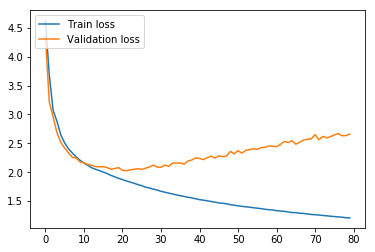

In [55]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

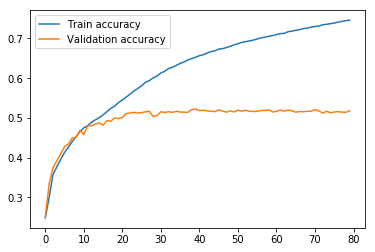

In [56]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

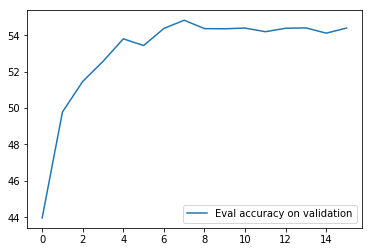

In [57]:
plt.plot(eval_acc)
plt.legend(['Eval accuracy on validation'], loc='lower right')
plt.show()

In [59]:
print "Best accuracy %.02f on epoch %d" % (max(eval_acc), (1 + np.argmax(np.array(eval_acc))) * eval_every)

Best accuracy 54.82 on epoch 40


In [61]:
# Load best epoch
model.load_weights("models/model_2/model_2_epoch_40_weights.h5")

In [62]:
evaluate(vqa_val, model, batch_size, ques_val_map, ans_val_map, img_val_map, id_to_ans, verbose=True)

100%|██████████| 121512/121512 [00:10<00:00, 11449.74it/s]


loading VQA annotations and questions into memory...
0:00:02.310095
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 54.82

Per Question Type Accuracy is the following:
are there : 83.14
what brand : 34.79
what room is : 88.09
what color is : 53.04
is : 77.93
are they : 76.90
what number is : 3.71
what sport is : 85.74
are : 71.97
is the : 74.71
what is the person : 49.18
how many : 39.48
does this : 79.36
is there a : 88.65
is he : 77.79
what : 35.54
does the : 77.18
is the person : 71.31
where is the : 26.66
what animal is : 59.17
how : 20.62
what is the woman : 41.43
none of the above : 52.23
who is : 24.09
is the woman : 75.33
are the : 74.40
how many people are : 38.44
what is on the : 32.23
has : 78.96
was : 79.37
what type of : 44.56
is this an : 76.85
do : 74.86
what is the man : 51.70
which : 39.66
a

54.82